In [1]:
# This cell is only for setting parameter defaults - gets replaced by sidecar.
day_obs = "2024-08-14"
tel = "AuxTel"  
#tel = "SimonyiTel"
instrument = "latiss"  
#instrument = "lsstcomcamsim"
index = 2
#index = 3
#timezone = "Chile/Continental"
timezone = "UTC"

# Scheduler: Targets, Observations and ConsDB Visits for {{ param.dayobs }} - {{ param.tel }}

The Feature Based Scheduler requests `Targets` and completed observation scripts result in `Observations`. Data is tracked in the EFD.
The Consdb reports acquired `Visits`. 

In [2]:
import os
import copy
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
from cycler import cycler
import colorcet as cc

import pandas as pd
from IPython.display import display, Markdown

import datetime
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

import datetime
import pytz
timezone = "Chile/Continental"
tz = pytz.timezone(timezone)

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site

import requests
import sqlalchemy
from lsst_efd_client import EfdClient
try:
    from lsst.summit.utils import ConsDbClient
    have_consdb = True
except ImportError:
    have_consdb = False

# for scheduler snapshots
from urllib.parse import urlparse
from lsst.resources import ResourcePath


# at USDF or at summit?
if os.getenv("EXTERNAL_INSTANCE_URL", "") == "https://summit-lsp.lsst.codes":
    efd = 'summit_efd'
else:
    efd = 'usdf_efd'  
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"
# Not sure of summit consdb access, just use USDF for now
os.environ["LSST_CONSDB_PQ_URL"] = "http://consdb-pq.consdb:8080/consdb"
os.environ["no_proxy"] += ",.consdb"

%matplotlib inline

/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
minutes_to_days = 1./60/24
seconds_to_days = 1./60/60/24

In [4]:
site = Site('LSST')
almanac = Almanac()
night_events = almanac.get_sunset_info(evening_date=day_obs, longitude=site.longitude_rad)
sunset = Time(night_events['sunset'], format='mjd', scale='utc') 
sunrise = Time(night_events['sun_n12_rising'], format='mjd', scale='utc')
survey_length = sunrise.mjd - sunset.mjd
display(Markdown(f"<strong>On {day_obs}:</strong>"))
print(f"12-deg sunset at {sunset.iso} 12-deg sunrise at {sunrise.iso}, for a {survey_length * 24} hour night")
moon_phase = almanac.get_sun_moon_positions(sunset.mjd)['moon_phase']
print(f"Moonrise is at {Time(night_events['moonrise'], format='mjd', scale='utc').iso}, moonset at {Time(night_events['moonset'], format='mjd', scale='utc').iso},"
      f"with a phase of {moon_phase :.1f}.")

<strong>On 2024-08-14:</strong>

12-deg sunset at 2024-08-14 22:14:06.497 12-deg sunrise at 2024-08-15 10:23:27.282, for a 12.155773635953665 hour night
Moonrise is at 2024-08-15 17:55:58.086, moonset at 2024-08-15 07:49:01.139,with a phase of 65.0.


In [5]:
efd_client = EfdClient(efd)

In [6]:
# The scheduler could be set up before sunset.
early_setup = sunset - TimeDelta(5*60*60, format='sec')
# And the blocks could be added before sunset, but let's avoid some afternoon calibs
early_block = sunset - TimeDelta(1*60*60, format='sec')

# What versions of the Scheduler modules are being used
display(Markdown("<strong>Versions</strong>"))
topic = 'lsst.sal.Scheduler.logevent_dependenciesVersions'
fields = await efd_client.get_fields(topic)
fields = [f for f in fields if "private" not in f]
dd = await efd_client.select_time_series(topic, fields, early_setup, sunrise, index=index)
display(dd)

# How is the FBS and Scheduler configured 
display(Markdown("<strong>Configurations applied</strong>"))
topic = 'lsst.sal.Scheduler.logevent_configurationApplied'
fields = await efd_client.get_fields(topic)
dd = await efd_client.select_time_series(topic, fields, early_setup, sunrise, index=index)
if len(dd) == 0:
    print(f"No scheduler configurations applied between {sunset.iso} and {sunrise.iso}")
else:
    for i, row in dd[['configurations', 'schemaVersion', 'url']].iterrows():
        print(i, row.configurations)
        print(i, row.schemaVersion, row.url)
print()

# What other BLOCKS have been requested in this night (outside the FBS)
display(Markdown("<strong>JSON BLOCKS</strong>"))
topic = 'lsst.sal.Scheduler.command_addBlock'
fields = await efd_client.get_fields(topic)
fields = [f for f in fields if 'private' not in f]
dd = await efd_client.select_time_series(topic, fields, early_block, sunrise, index=index)
if len(dd) == 0:
    print(f"No JSON BLOCKS added between {sunset.iso} and {sunrise.iso}")
else:
    display(dd)

<strong>Versions</strong>

,SchedulerID,cloudModel,downtimeModel,observatoryLocation,observatoryModel,priority,salIndex,scheduler,seeingModel,skybrightnessModel,version
2024-08-14 20:21:58.505373+00:00,None,1.1.0,1.1.0,1.3.0,1.2.0,None,2,feature_scheduler,1.1.0,1.5.2,
2024-08-14 23:19:20.537274+00:00,None,1.1.0,1.1.0,1.3.0,1.2.0,None,2,feature_scheduler,1.1.0,1.5.2,


<strong>Configurations applied</strong>

2024-08-14 20:21:58.506112+00:00 _init.yaml,_summit.yaml,auxtel_fbs_image_photocal.yaml
2024-08-14 20:21:58.506112+00:00 v6 file:///net/obs-env/auto_base_packages/ts_config_ocs/Scheduler/v6
2024-08-14 23:19:20.538025+00:00 _init.yaml,_summit.yaml,auxtel_fbs_image_photocal.yaml
2024-08-14 23:19:20.538025+00:00 v6 file:///net/obs-env/auto_base_packages/ts_config_ocs/Scheduler/v6



<strong>JSON BLOCKS</strong>

,id,override,salIndex
2024-08-14 21:42:00.665856+00:00,setup_latiss_calibrations,,2
2024-08-14 21:44:54.684848+00:00,latiss_daily_calibrations,,2
2024-08-14 22:54:53.167808+00:00,shutdown_latiss_calibrations,,2


In [7]:
# Fetch requested targets
topic = 'lsst.sal.Scheduler.logevent_target'
all_fields = await efd_client.get_fields(topic)
#print(all_fields)
targets = await efd_client.select_time_series(topic, all_fields, sunset, sunrise, index=index)

# When estimating obsmjd expected from target -- include the previous
# exposure time or not? (in theory, should. in practice, queue is busy so not including it can be helpful).
include_prev_exptime = False

def demangle_note(x):    
    # remove _expnum
    x.target = copy.deepcopy(x.note)
    if "IM" in x.note:
        x.note = x.note.split(":")[1].split("_")[0]
    if 'spec' in x.note:
        x.note = 'HD' + x.note.split('HD')[-1]
    return x

if len(targets) == 0:
    print(f"On night {day_obs} {tel} recorded {len(targets)} targets")
    print(f"This was for times between {sunset.iso}, {sunrise.iso}")

    # debug help -- 
    targets = await efd_client.select_top_n(topic, all_fields, 2, index=index)
    print("The most recent targets were recorded were:")
    display(targets[['SchedulerID', 'airmass', 'ra', 'decl', 'skyAngle', 'exposureTimes0', 'skyBrightness', 'slewTime', 'note', 'salIndex']])

else:

    # target timestamp in EFD = time that the target is pushed to scriptqueue
    # this should be at the start of the previous observation
    targets["target_time"] = targets.index.copy()
    targets["target_mjd"] = Time(targets.index).mjd
    # estimate what time this target should be observed (start of observation)
    # == target_time + previous exposure time (?) + slew time
    cols = [c for c in targets if 'exposureTimes' in c]
    targets['total_exptime'] = targets[cols].sum(axis=1)
    
    # Try to fix the exposure times, to match JSON values
    total_exptime = targets['total_exptime'].values
    for i, (idx, row) in enumerate(targets.iterrows()):
        if 'spec' in row.note:
            total_exptime[i] = 495
        if 'bright' in row.note:
            total_exptime[i] = 152
        if 'cwfs' in row.note:
            # Honestly, we can't really tell with cwfs because
            # there seem to be highly variable sequences
            total_exptime[i] = 8 * 30            
    #targets['total_exptime'] = total_exptime

    previous_exposure_time = np.concatenate([np.array([0]), targets['total_exptime'][:-1]])
    # The target is supposed to be issued to the EFD when it hits the top of the scriptqueue 
    # which is supposed to be when the previous observation starts ... however
    # an observation having many scripts may mean it doesn't hit the top of the scriptqueue then.
    # (so this is probably more like a range of target.mjd + slewtime --- target + slewtime + previous exposure
    targets["previous_exptime"] = previous_exposure_time
    targets["target_obsmjd"] = Time(targets.index).mjd  + (targets['slewTime'])*seconds_to_days 
    if include_prev_exptime:
        targets["target_obsmjd"] += (targets["previous_exptime"])*seconds_to_days
    
    # mangle the note again 
    targets['orig_note'] = targets.note.copy()
    targets = targets.apply(demangle_note, axis=1)
    
    targets = targets.sort_values(by='target_obsmjd')
    targets['target_id'] = np.arange(0, len(targets), 1)
    targets = targets.reset_index(drop=True)
    
    print(f"On night {day_obs} {tel} recorded {len(targets)} targets for \n{targets.note.unique()}") 

On night 2024-08-14 AuxTel recorded 42 targets for 
['cwfs' 'HD185975' 'HD202025' 'HD146233' 'HD205905' 'HD177517' 'HD2811']


In [8]:
# Observations are the completed observation script .. to be compared with visits from the consdb

topic = 'lsst.sal.Scheduler.logevent_observation'
all_fields = await efd_client.get_fields(topic)
obs = await efd_client.select_time_series(topic, all_fields, sunset, sunrise, index=index)

if len(obs) == 0:
    print(f"On night {day_obs} aux tel recorded {len(obs)} observations")

else:
    # timestamp is the time of successful end of observation/JSON block
    obs['obs_time'] = obs.index.copy()
    # Try to fix incorrect exposure times
    #exptimes = obs['exptime'].values
    #exptimes = np.where(exptimes == 360, 152, exptimes)
    #exptimes = np.where(exptimes == 420, 495, exptimes)
    #obs['exptime'] = exptimes

    # obs time - exposure time should be start of observation (if exposure time is correct)
    obs['obs_obsmjd'] = Time(obs.index).mjd - (obs['exptime'] * seconds_to_days)
    
    obs = obs.sort_values(by='obs_obsmjd')
    obs['obs_id'] = np.arange(0, len(obs), 1)
    obs = obs.reset_index(drop=True)
    
    print(f"On night {day_obs} {tel} recorded {len(obs)} observations") 

On night 2024-08-14 AuxTel recorded 31 observations


In [9]:
def match_obs_and_targets(obs, targets):
    # Check targets -> observations
    target_to_obs_match = np.zeros(len(targets), int)
    obs_to_target_match = np.zeros(len(obs), int)

    count = 0
    for i, (ri, t) in enumerate(targets.iterrows()):
        # Match obs_mjd, ra/dec/filter from target+observation
        # the target.obs_mjd may overestimate actual mjd by ~ previous exposure
        # if slewtime is inaccurate, target_obs.mjd may be inaccurate
        # if visit includes JSON BLOCK with many steps, could be delays 
        # so that obs_obsmjd is later than reality
        # some targets may never get completed observations
        slew_error = 2.0 * minutes_to_days
        target_error = t.previous_exptime
        # prevents matching to "wrong version" of target
        X = 28 * minutes_to_days
        match = np.where((np.abs(t.target_obsmjd - obs.obs_obsmjd) < target_error + slew_error) # close in time
                         & ((obs.obs_obsmjd - t.target_obsmjd) <= X) # not more than X
                         & (t.ra == obs.ra) 
                         & (t.decl == obs.decl) 
                         & (t['filter'] == obs['filter'])
                         & (obs_to_target_match == 0))[0]
        if len(match) == 0:
            print(f'no obs match for target {t.target_id}')
            count += 1
            target_to_obs_match[i] = -1
        else:
            # Consider target to have found the best match 
            # in the first (soonest) of 'match'
            idx = match[0]
            target_to_obs_match[i] = obs.iloc[idx]['obs_id']
            # And consider observation to have found a match
            obs_to_target_match[idx] = t['target_id']

    obs['target_id'] = np.array(obs_to_target_match)
    targets['obs_id'] = np.array(target_to_obs_match)
    
    print(f'failed to match {count} targets to observations')
    print(f'compare to {len(targets) - len(obs)} expected difference')
    return obs, targets

In [10]:
if len(obs) > 0:
    obs, targets = match_obs_and_targets(obs, targets)

no obs match for target 5
no obs match for target 9
no obs match for target 18
no obs match for target 20
no obs match for target 21
no obs match for target 24
no obs match for target 25
no obs match for target 28
no obs match for target 38
no obs match for target 39
no obs match for target 41
failed to match 11 targets to observations
compare to 11 expected difference


In [11]:
if len(obs) > 0:
    # Join targets + obs
    jj = obs.join(targets, on='target_id', lsuffix='_o', rsuffix='_t')
    jj = jj.sort_values(by='obs_obsmjd')
    
    jj['delta_obs'] = np.concatenate([np.array([0]), np.diff(jj['obs_obsmjd'])/minutes_to_days]) # minutes -- should be close to expected overhead
    jj['delta_request'] = (jj['obs_obsmjd'] - jj['target_obsmjd']) / minutes_to_days # minutes  -- should be close to 0
    jj['expected_overhead'] = (jj['previous_exptime']+ jj['slewTime'])/60 # minutes
else:
    jj = []

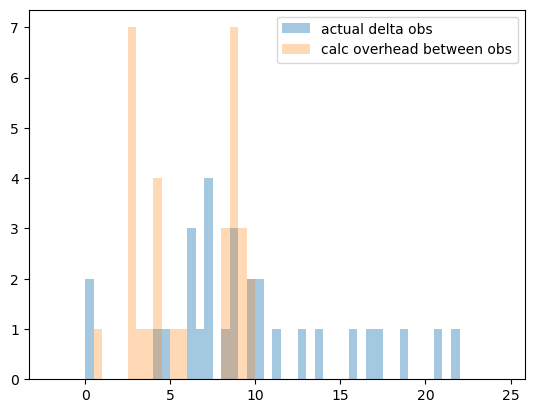

In [12]:
if len(jj) > 0:
    _ = plt.hist(jj['delta_obs'], bins=np.arange(-2, 25, 0.5), alpha=0.4, histtype='bar', label='actual delta obs')
    _ = plt.hist(jj['expected_overhead'], bins=np.arange(-2, 25, 0.5), alpha=0.3, histtype='bar', label='calc overhead between obs')
    #_ = plt.hist(jj['delta_request'], bins=np.arange(-2, 25, 0.5), alpha=0.3, histtype='bar', label='delta expected obs time')
    plt.legend()

In [13]:
# Where did the time between observations just take longer than expected 
# delta obs compared to (slewTime + exptime) BUT sheduler target estimate was correct

overhead_error = 6

if len(jj)>0: 
    overheads = np.where(np.abs(jj.delta_obs - jj.expected_overhead) > overhead_error)
    
    breaks = []
    for b in overheads[0]:
        b_start = jj.iloc[b-1]['obs_obsmjd'] # + jj.iloc[b-1]['exptime']/60/60/24
        b_end = jj.iloc[b]['obs_obsmjd'] #- jj.iloc[b]['slewTime']/60/60/24
        if (jj.iloc[b-1]['note'] == 'cwfs') | (jj.iloc[b]['note'] == 'cwfs') | (jj.iloc[b+1]['note'] == 'cwfs'):
            # We can probably disregard many of these, for now, as cwfs sweeps 
            # seem to mess with queue order and have variable length
            # but also, when we come out of "break", a real fault will tend to have a cwfs sequence.
            # So try to distinguish these. 
            if b_end - b_start >= 10:
                breaks.append([b_start, b_end])
            else:
                continue
        else:
            breaks.append([b_start, b_end])

    # should also highlight anywhere there are more than one failed target in a row
    t = targets.query('obs_id == -1')
    i = 1
    break_start = t['target_obsmjd'].iloc[0]
    while i < len(t):
        if (t['target_id'].iloc[i] - t['target_id'].iloc[i-1] > 1) | (i == len(t) - 1):
            # We skipped more than one target id, so passed the end of the break
            break_end = t['target_obsmjd'].iloc[i-1]
            breaks.append([break_start, break_end])
            break_start = t['target_obsmjd'].iloc[i]
        i += 1
    
    
print(len(overheads[0]), len(breaks))

14 17


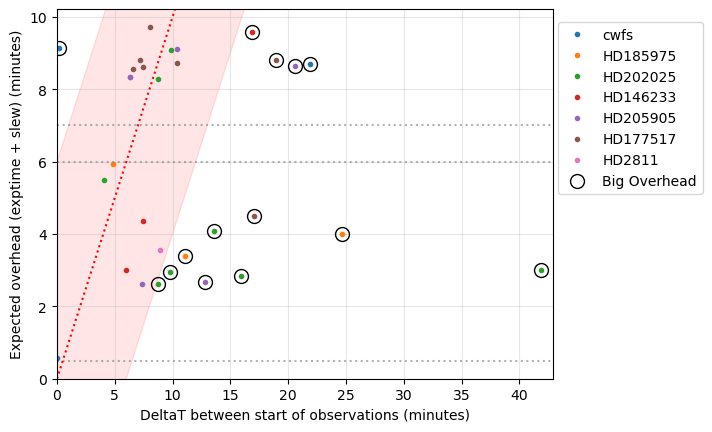

In [14]:
if len(jj) > 0:
    plt.figure()
    
    eps = 1
    for note in jj.note.unique():
        j = jj.query('note == @note')
        plt.plot(j.delta_obs, j.expected_overhead, '.', label=note)
    j = jj.iloc[overheads]
    plt.plot(j.delta_obs, j.expected_overhead, 'o',
             markersize=10, color='k', markerfacecolor='none', label='Big Overhead')
    plt.legend(loc=(1.01, 0.5))
    for exptime in jj.exptime.unique():
        plt.axhline(exptime/60, color='gray', linestyle=':', alpha=0.6)
    
    x = np.arange(0, 60)
    plt.plot(x, x, 'r:')
    plt.fill_between(x, x-overhead_error, x+overhead_error,  color='r', alpha=0.1)
    plt.grid(True, alpha=0.3)
    
    plt.xlim(0, np.max(jj.delta_obs) + eps)
    plt.ylim(0, np.max(jj.expected_overhead) + eps/2)
    
    plt.xlabel("DeltaT between start of observations (minutes)")
    plt.ylabel("Expected overhead (exptime + slew) (minutes)")

In [15]:
# Add consdb

day_obs_int = int(day_obs.replace('-', ''))

visit_query = f'''
    SELECT * FROM cdb_{instrument}.visit1
     where day_obs = {day_obs_int}
'''

quicklook_query = f'''
    SELECT q.*  FROM cdb_{instrument}.visit1_quicklook as q,
    cdb_{instrument}.visit1 as v
     WHERE v.day_obs = {day_obs_int} and q.visit_id = v.visit_id
'''

if have_consdb:
    # Use the ConsDB Client, and add a couple of tries 
    consdb = ConsDbClient()
    
    try:
        visits = consdb.query(visit_query).to_pandas()
    except requests.HTTPError or requests.JSONDecodeError:
        # Try twice
        visits = consdb.query(visit_query).to_pandas()

    quicklook = consdb.query(quicklook_query).to_pandas()

else:
    # Assumes at the USDF
    connect = sqlalchemy.create_engine('postgresql://usdf@usdf-summitdb.slac.stanford.edu/exposurelog')
    visits = pd.read_sql(visit_query, connection)
    quicklook = pd.read_sql(quicklook_query, connection)

if len(visits) > 0:
    print(f"Retrieved {len(visits)} visits from consdb")
    obj_vis = len(visits.query('img_type == "OBJECT"'))
    print(f"About {obj_vis} of these are object images")

if len(quicklook) > 0:
    visits = visits.join(quicklook, on='visit_id', lsuffix='', rsuffix='_q')
    print(f"And added quicklook stats")

if len(visits) == 0:
    print(f"No visits for {tel} on {day_obs} retrieved from consdb")

Retrieved 618 visits from consdb
About 146 of these are object images


In [16]:
verbose = False
short_cols = ['seq_num', 'obs_start_mjd', 'obs_end_mjd', 'exp_time', 'shut_time', 'dark_time', 's_ra', 's_dec', 'band', 'airmass', 
              'img_type', 'target_name', 'science_program', 'observation_reason', 'dimm_seeing']
if len(visits)>0 and verbose:
    display(visits[short_cols])

In [17]:
# construct a 'note' to match visits with the target/observation colors
def construct_note(x):
    if x.science_program == 'cwfs' or x.science_program == 'cwfs-focus-sweep':
        note = 'cwfs'
    elif x.science_program == "BLOCK-295":
        note = 'calibrations'
    elif x.target_name == 'FlatField position':
        note = 'calibrations'
    elif x.science_program == 'AUXTEL_PHOTO_IMAGING':
        note = x.target_name.split('_')[0]
    elif x.science_program == 'spec-survey':
        note = x.target_name
    else:
        note = 'unknown'
    return note

if len(visits)>0:
    note = visits.apply(construct_note, axis=1)
    visits['note'] = note

In [18]:
def mjd_to_datetime(mjd):
    return Time(mjd, format='mjd', scale='utc').to_datetime(timezone=tz)

Text(0, 0.5, 'Airmass')

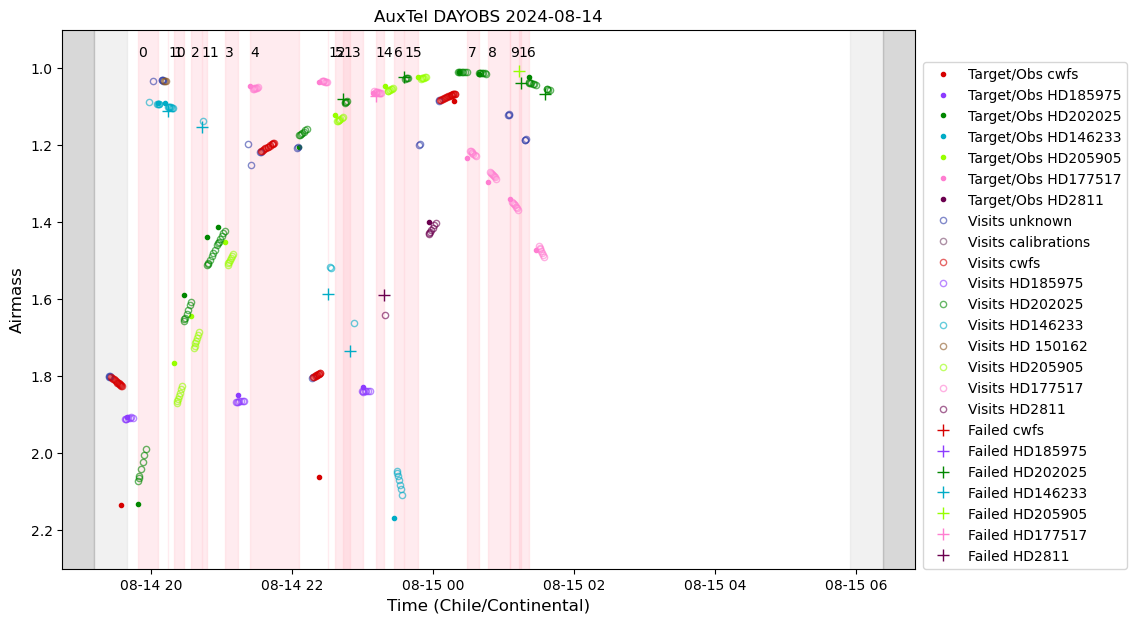

In [19]:
eps = 1
plt.figure(figsize=(11, 7))
plt.title(f"{tel} DAYOBS {day_obs}")


plt.fill_between([mjd_to_datetime(night_events['sun_n12_setting']), 
                  mjd_to_datetime(night_events['sun_n18_setting'])],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([mjd_to_datetime(night_events['sunset']), 
                 mjd_to_datetime(night_events['sun_n12_setting'])], 
                  2.5, 0.0, color='gray', alpha=0.3)
plt.fill_between([mjd_to_datetime(night_events['sun_n18_rising']), 
                 mjd_to_datetime(night_events['sun_n12_rising'])],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([mjd_to_datetime(night_events['sun_n12_rising']), 
                 mjd_to_datetime(night_events['sunrise'])],
                 2.5, 0.0, color='gray', alpha=0.3)

plt.axvline(mjd_to_datetime(night_events['moonrise']), linestyle=':', color='blue', alpha=0.3)

plot_fbs = True
if len(jj) == 0:
    plot_fbs = False
plot_visits = True
if len(visits) == 0:
    plot_visits = False

# Assign distinct target sets with different colors
if len(jj) > 0:
    notes = jj.note.unique()
    note_colors = {}
    for i, n in enumerate(notes):
        note_colors[n] = cc.glasbey[i]
elif len(visits) > 0:
    notes = visits.note.unique()
    note_colors = {}
    for i, n in enumerate(notes):
        note_colors[n] = cc.glasbey[i]
else:
    plot_fbs = False
    plot_visits = False


if plot_fbs:
    # Plot the successfully recorded 'observation' scripts
    for note in jj.note.unique():
        j = jj.query('note == @note')
        plt.plot(mjd_to_datetime(j.obs_obsmjd), j.airmass, '.', 
                 color=note_colors[note], label=f"Target/Obs {note}")
    
    if len(breaks) > 0:
        for break_count, b in enumerate(breaks):
            plt.fill_between(mjd_to_datetime(b), 2.5, 0.0, color='pink', alpha=0.3)
            plt.text(mjd_to_datetime(b[0]), 0.97, break_count)

    # Plot the observations that come after what looks like big overheads
    #j = jj.iloc[overheads]
    #plt.plot(j.obs_obsmjd, j.airmass, 'o', 
    #         markersize=10, color='k', markerfacecolor='none', label='Big Overheads')

i = len(cc.glasbey) - 1
if plot_visits:
    # Plot the visits recorded in the consdb 
    for note in visits.note.unique():
        try:
            color = note_colors[note]
        except KeyError:
            color = cc.glasbey[i]
            i -= 1
        v = visits.query('note == @note')
        plt.plot(mjd_to_datetime(v.obs_start_mjd), v.airmass, '.', 
                 markersize=9, markerfacecolor='none', alpha=0.6,
                 label=f'Visits {note}', color=color, zorder=3)

if plot_fbs:
    # Plot the targets which did not get 'observations' recorded
    for note in targets.note.unique():
        try:
            color = note_colors[note]
        except KeyError:
            color = cc.glasbey[i]
            i -= 1
        t = targets.query('note == @note and obs_id == -1')
        plt.plot(mjd_to_datetime(t.target_obsmjd), 
                 t.airmass, '+', markersize=9, 
                 label=f'Failed {note}', color=color, zorder=1)


plt.legend(loc=(1.01, 0.0))

plt.xlim(mjd_to_datetime(night_events['sunset']+30/60/24), 
         mjd_to_datetime(night_events['sunrise']-30/60/24))
#plt.xlim(mjd_to_datetime(60516.057851-30/60/24), mjd_to_datetime(60516.076206+30/60/24))
plt.ylim(2.3, 0.9)

plt.xlabel(f"Time ({tz})", fontsize="large")
plt.ylabel("Airmass", fontsize="large")

In [20]:
topics = await efd_client.get_topics()
if tel.lower().startswith('aux'):
    err_topics = [t for t in topics if 'err' in t and 'MT' not in t]
else:
    err_topics = [t for t in topics if 'err' in t and 'AT' not in t]

try: 
    breaks
except NameError:
    breaks = [[sunset, sunrise]]

for i, b in enumerate(breaks):
    t1 = Time(b[0], format='mjd', scale='utc')
    t2 = Time(b[1], format='mjd', scale='utc')
    print(f"During break {i} ({round((t2-t1).sec/60)} minutes)- {mjd_to_datetime(t1.mjd)} to {mjd_to_datetime(t2.mjd)} : ")
    # Poll error topics
    for topic in err_topics:
        df = await efd_client.select_time_series(topic, ['errorCode', 'errorReport'], t1, t2)
        if len(df) > 0:
            print(' ', topic)
            for ij, row in df.iterrows():
                print(f"   {mjd_to_datetime(Time(ij).mjd)} {row.errorReport}")
    # Also check what was going on in scriptqueue
    df = await efd_client.select_time_series('lsst.sal.ScriptQueue.logevent_script', ['path'], t1, t2, index=index)
    if len(df) > 0:
        print(f'  Scripts: {df.path.unique()}') 
    print('')

During break 0 (17 minutes)- 2024-08-14 19:48:43.127960-04:00 to 2024-08-14 20:05:34.268959-04:00 : 
  Scripts: ['auxtel/latiss_acquire_and_take_sequence.py'
 'auxtel/latiss_take_sequence.py' 'auxtel/offset_atcs.py'
 'auxtel/correct_pointing.py']

During break 1 (9 minutes)- 2024-08-14 20:18:53.681766-04:00 to 2024-08-14 20:27:36.157868-04:00 : 
  Scripts: ['auxtel/latiss_acquire_and_take_sequence.py'
 'auxtel/latiss_take_sequence.py' 'auxtel/offset_atcs.py']

During break 2 (14 minutes)- 2024-08-14 20:33:53.389667-04:00 to 2024-08-14 20:47:30.164945-04:00 : 
  Scripts: ['auxtel/latiss_take_sequence.py' 'auxtel/offset_atcs.py'
 'auxtel/latiss_acquire_and_take_sequence.py']

During break 3 (11 minutes)- 2024-08-14 21:02:33.999611-04:00 to 2024-08-14 21:13:39.477928-04:00 : 
  Scripts: ['auxtel/latiss_take_sequence.py' 'auxtel/offset_atcs.py'
 'auxtel/latiss_acquire_and_take_sequence.py']

During break 4 (42 minutes)- 2024-08-14 21:24:00.998580-04:00 to 2024-08-14 22:05:55.356366-04:00 :

In [21]:
# Grab information from the narrative log -- 
# How to tell what is auxtel and what is simonyi or other system? do we care or is this for the reader? 
connection = sqlalchemy.create_engine('postgresql://usdf@usdf-summitdb.slac.stanford.edu/narrativelog')

narrative_query = f"select site_id, message_text, time_lost, date_begin, date_invalidated, systems, \
    subsystems, cscs, date_end, time_lost_type from message where date_begin between '{sunset.iso}' and '{sunrise.iso}'"

narrative_log = pd.read_sql(narrative_query, connection)

In [22]:
# Host usdf-summitdb.slac.stanford.edu, database narrativelog, schema public, table message
# Host usdf-summitdb.slac.stanford.edu, database exposurelog, schema public, table message (consdb is in exposurelog too)

In [23]:
#narrative_log

In [24]:
for i, row in narrative_log.iterrows():
    t_start = Time(row["date_begin"])
    t_end = Time(row["date_end"])
    print(f"Log message at: {t_start} to {t_end} ({t_start.mjd} {t_end.mjd})")
    print('time lost', row['time_lost'], 'time lost type', row['time_lost_type'], 'systems', row['systems'], 'subsystems', row['subsystems'], 'CSCS', row['cscs'])
    print(row["message_text"].replace("\r\n\r\n", ""))
    if row['date_invalidated'] is not None:
        print(f"Date invalidated {row['date_invalidated']}")
    print('\n')

Log message at: 2024-08-15 03:20:43.992000 to 2024-08-15 03:20:43.992000 (60537.13939805556 60537.13939805556)
time lost 0 days 00:00:00 time lost type fault systems None subsystems None CSCS None
At   03:19:17 TAI  - SALindex: 202324
Timeout waiting for the data to be ingested.

Date invalidated NaT


Log message at: 2024-08-15 00:46:24.774000 to 2024-08-15 00:46:24.774000 (60537.03223118056 60537.03223118056)
time lost 0 days 00:00:00 time lost type fault systems None subsystems None CSCS None
At 0:44:03 TAI   --  SALindex 202140
 
Timed out waiting for the data to be ingested. 
People are working on this issue, the file system is having problems.

Date invalidated NaT


Log message at: 2024-08-15 01:24:22.718000 to 2024-08-15 01:24:22.718000 (60537.05859627315 60537.05859627315)
time lost 0 days 00:00:00 time lost type fault systems None subsystems None CSCS None
At 01:22:38 TAI   SALindex 202175
Timeout waiting for the data to be ingested.

Date invalidated NaT


Log message at: 20